# Advection with varying isotropic diffusion 

### Neumann boundary conditons

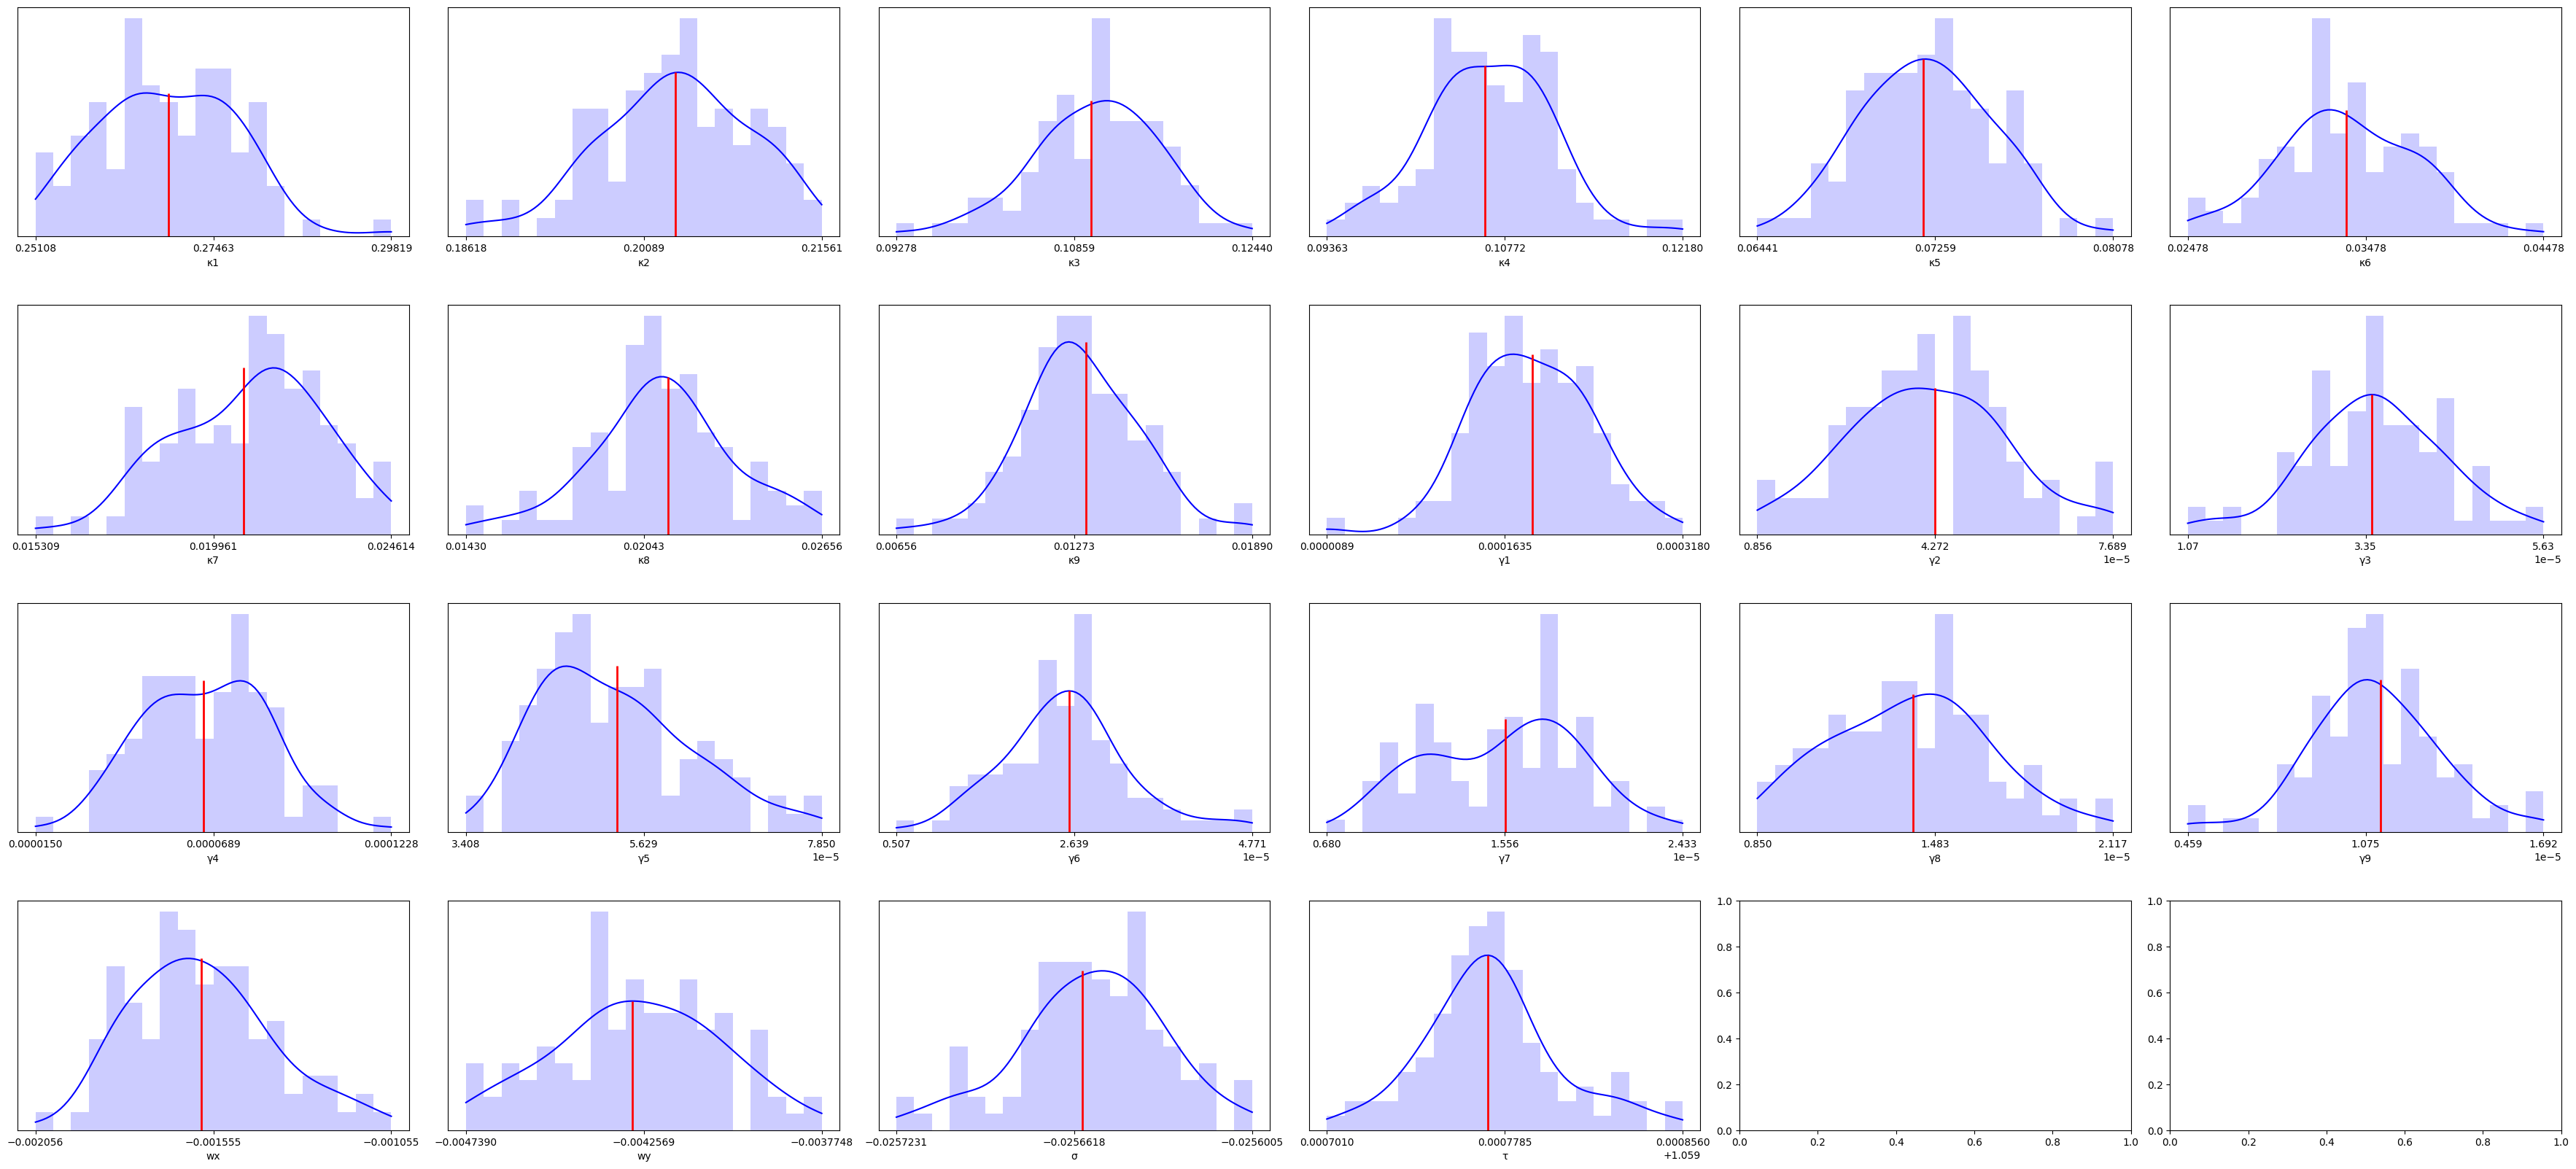

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/advection-var-idiffusion-2D-bc1.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 6
n = 4
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.hstack([["\u03BA%d"%i for i in range(1,10)], 
                    ["\u03B3%d"%i for i in range(1,10)], 
                    "wx" ,"wy", "\u03C3", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)

### Dirichlet boundary conditions

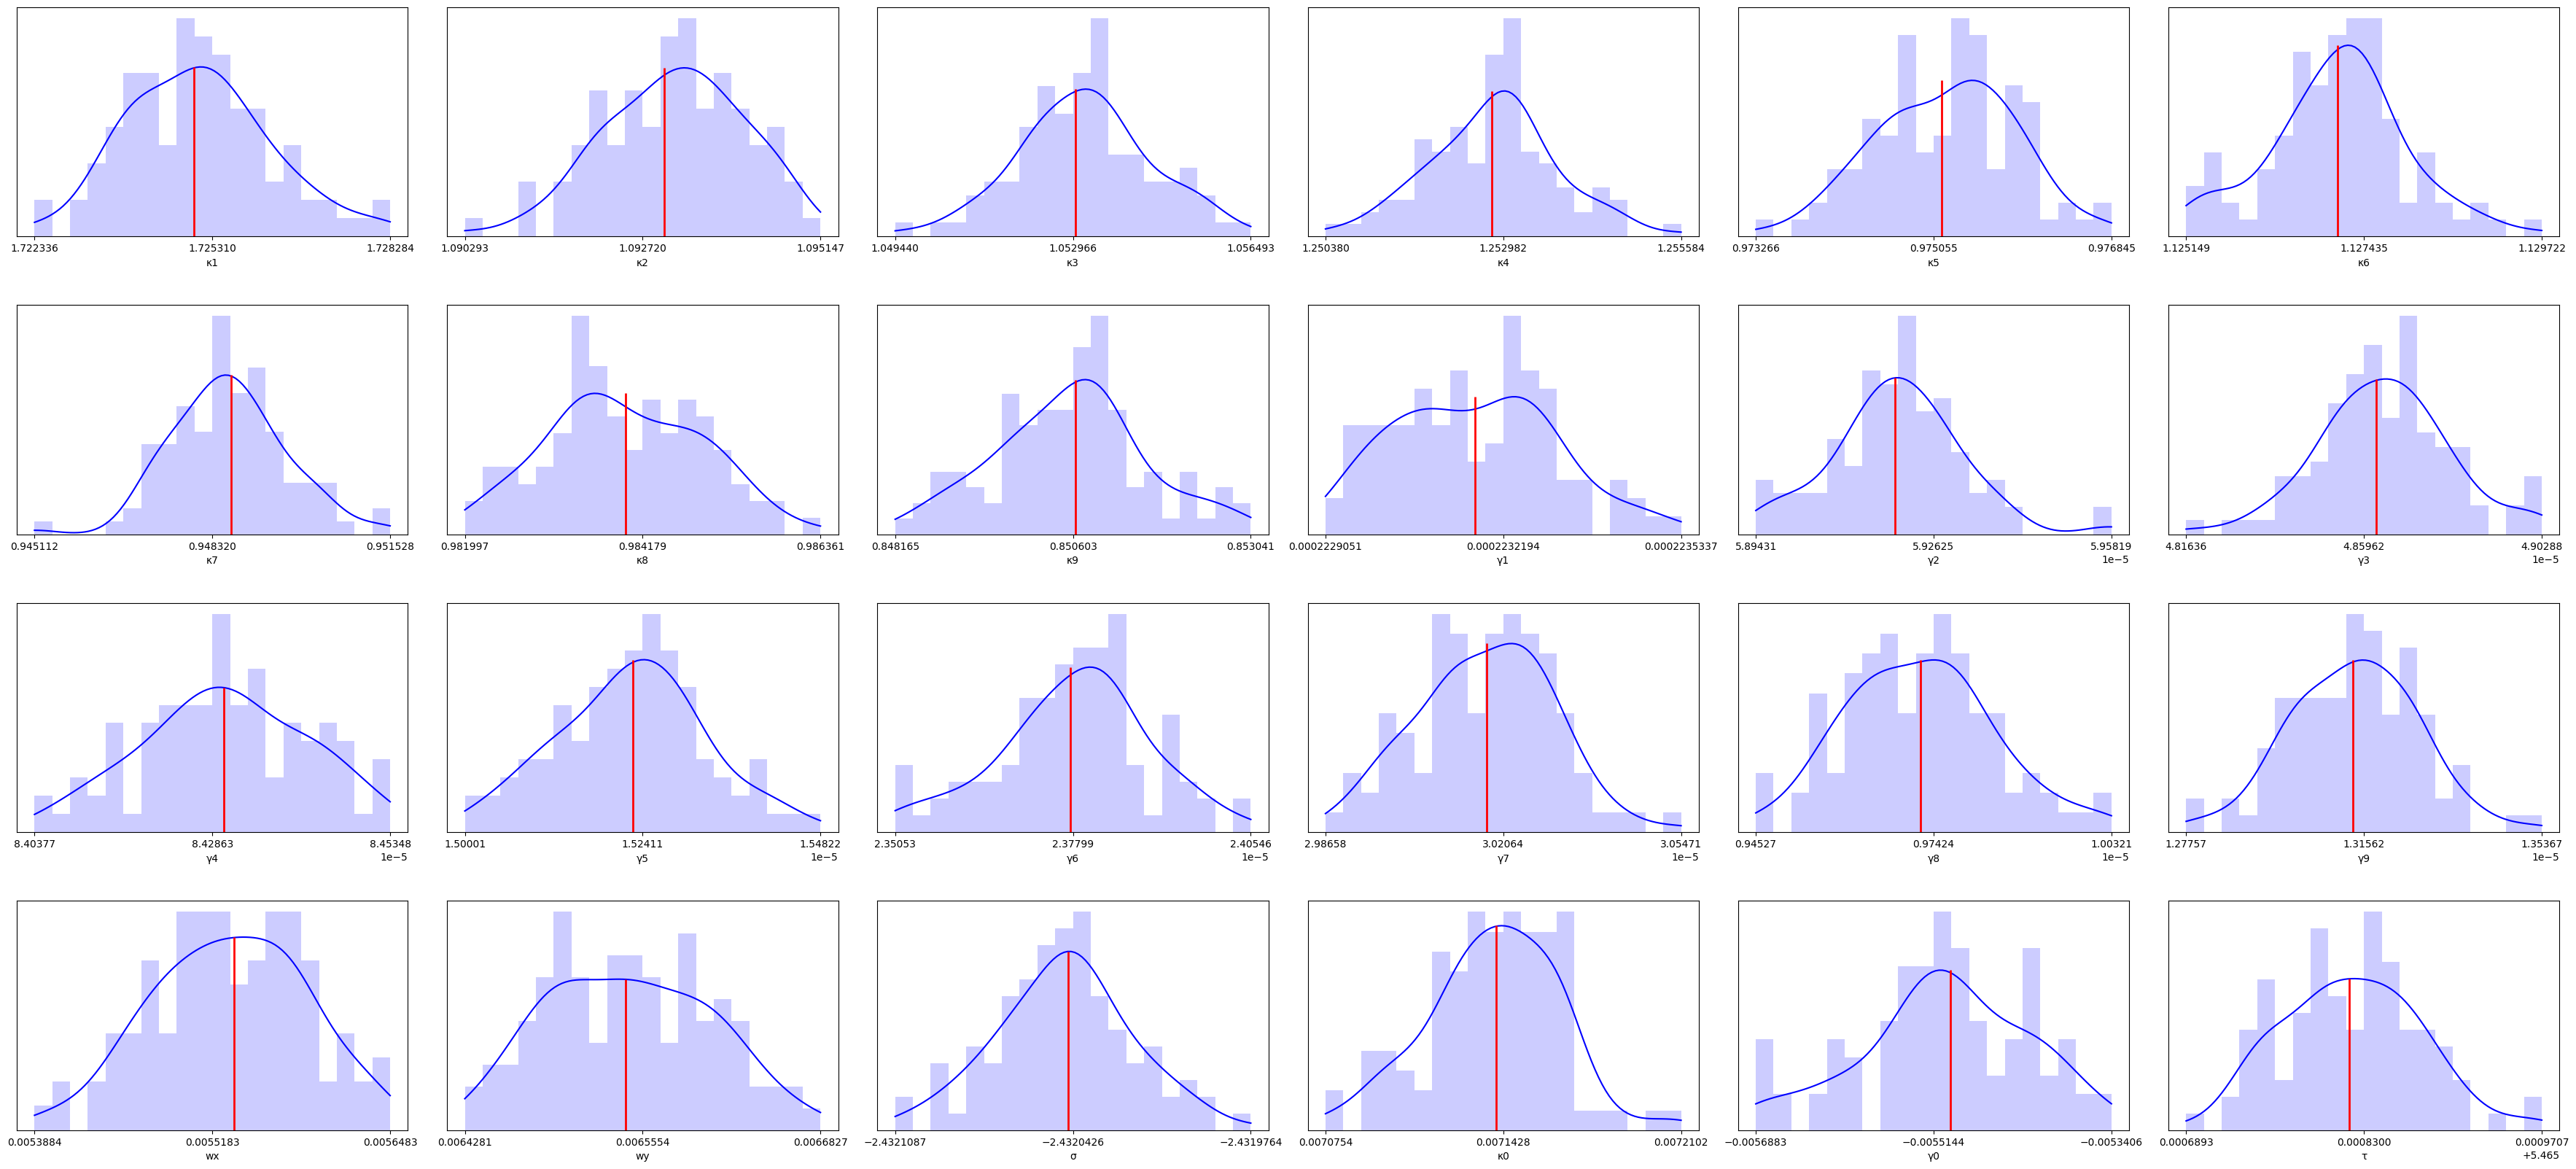

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/advection-var-idiffusion-2D-bc3.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 6
n = 4
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.hstack([["\u03BA%d"%i for i in range(1,10)], 
                    ["\u03B3%d"%i for i in range(1,10)], 
                    "wx" ,"wy", "\u03C3","\u03BA0", "\u03B30", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)

#### Visualization

In [ ]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

data = sp.datasets.get_sinmod_training()
bc = 3
spde = 'advection-var-diffusion'
mod0 = sp.model(grid = sp.grid(x=data['x'], y=data['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = False)
mod = sp.model(grid = sp.grid(x=data['x'], y=data['y'], t = data['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = False, Q0 = mod0.mod.Q,
        parameters = np.load('../fits/%s_bc%d.npy'%(spde,bc)))
mod.mod.setPars(mod.mod.initFit(data['mut']))
mod.mod.setQ()

#### Prediction on test set

In [1]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

data = sp.datasets.get_sinmod_training()
bc = 3
spde = 'advection-var-diffusion'
mod0 = sp.model(grid = sp.grid(x=data['x'], y=data['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = False)
mod = sp.model(grid = sp.grid(x=data['x'], y=data['y'], t = data['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = False, Q0 = mod0.mod.Q)
mod.mod.setPars(mod.mod.initFit(data['mut']))
mod.mod.setQ()

# Advection

In [2]:
ws = np.array([mod.mod.wx,mod.mod.wy],dtype="float64")
h = 0.00001
n = 100

res = []
for i in tqdm(range(n)):
    ngrad = []
    for i in range(ws.shape[0]):
        ws1 = ws.copy()
        ws2 = ws.copy()
        ws1[i] = ws1[i] + h
        ws2[i] = ws2[i] - h
        res1 = mod.mod.Aw(ws1)
        res2 = mod.mod.Aw(ws2)
        ngrad.append((res1.A - res2.A)/(2*h))
        
    sgrad = []
    sgrad.append(mod.mod.Aw(ws,diff = 1))
    sgrad.append(mod.mod.Aw(ws,diff = 2))

    res.append(np.allclose(ngrad[0], sgrad[0].A) and np.allclose(ngrad[1], sgrad[1].A))
    
print(np.all(res))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

True


# Diffusion

In [3]:
par = np.hstack([mod.mod.gamma],dtype=np.float64)

h = 0.000001
n = 100

res = []
for i in tqdm(range(n)):
    ngrad = []
    for i in range(par.shape[0]):
        par1 = par.copy()
        par2 = par.copy()
        par1[i] = par1[i] + h
        par2[i] = par2[i] - h
        gamma1 = np.exp(mod.grid.evalBH(par1))
        gamma2 = np.exp(mod.grid.evalBH(par2))
        Hs1 = (np.eye(2)*(np.stack([gamma1,gamma1],axis=2))[:,:,:,np.newaxis]) 
        Hs2 = (np.eye(2)*(np.stack([gamma2,gamma2],axis=2))[:,:,:,np.newaxis]) 
        ngrad.append((Hs1 - Hs2)/(2*h))
        
    sgrad = []
    gamma = np.exp(mod.grid.evalBH(par))
    for i in range(9):
        sgrad.append((np.eye(2)*(np.stack([mod.grid.bsH[:,:,i]*gamma,mod.grid.bsH[:,:,i]*gamma],axis=2)[:,:,:,np.newaxis])))
        

    res.append([np.allclose(ngrad[i], sgrad[i],atol = 1.0e-7, rtol = 1.0e-7) for i in range(par.shape[0])])

print(np.all(res))

  4%|▍         | 4/100 [00:00<00:03, 27.92it/s]

100%|██████████| 100/100 [00:03<00:00, 26.90it/s]

True


In [4]:
par = np.hstack([mod.mod.gamma],dtype=np.float64)

h = 0.000001
n = 100

res = []
for i in tqdm(range(n)):
    ngrad = []
    for i in range(par.shape[0]):
        par1 = par.copy()
        par2 = par.copy()
        par1[i] = par1[i] + h
        par2[i] = par2[i] - h
        gamma1 = np.exp(mod.grid.evalBH(par1))
        gamma2 = np.exp(mod.grid.evalBH(par2))
        Hs1 = (np.eye(2)*(np.stack([gamma1,gamma1],axis=2))[:,:,:,np.newaxis]) 
        Hs2 = (np.eye(2)*(np.stack([gamma2,gamma2],axis=2))[:,:,:,np.newaxis]) 
        res1 = mod.mod.Ah(Hs1)
        res2 = mod.mod.Ah(Hs2)
        ngrad.append((res1 - res2)/(2*h))
        
    sgrad = []
    gamma = np.exp(mod.grid.evalBH(par[:9]))
    
    for i in range(9):
        dgamma = mod.grid.bsH[:,:,i]*gamma
        dHs = (np.eye(2)*(np.stack([mod.grid.bsH[:,:,i]*gamma,mod.grid.bsH[:,:,i]*gamma],axis=2)[:,:,:,np.newaxis]))
        sgrad.append(mod.mod.Ah(dHs))

    res.append([np.allclose(ngrad[i].A, sgrad[i].A,atol = 1.0e-7, rtol = 1.0e-7) for i in range(par.shape[0])])

print(np.all(res))

100%|██████████| 100/100 [02:56<00:00,  1.77s/it]

True


# Q matrix

In [ ]:
par = mod.getPars()[:-1]

h = 0.000001
n = 100

ngrad = []
for i in range(par.shape[0]):
    par1 = par.copy()
    par2 = par.copy()
    par1[i] = par1[i] + h
    par2[i] = par2[i] - h
    Q1, Q_fac = mod.mod.makeQ(par1,grad = False)
    Q2, Q_fac = mod.mod.makeQ(par2,grad = False)
    ngrad.append((Q1 - Q2)/(2*h))
    
sgrad = []
Q, Q_fac, dQ = mod.mod.makeQ(par,grad = True)
sgrad = dQ



    #res.append( np.allclose(ngrad[0], sgrad[0]) and np.allclose(ngrad[1], sgrad[1]) and np.allclose(ngrad[2], sgrad[2]))



# log-likelihood

In [5]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

data = sp.datasets.get_sinmod_training()
bc = 3
spde = 'advection-var-diffusion'
mod0 = sp.model(grid = sp.grid(x=data['x'], y=data['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = False)
mod = sp.model(grid = sp.grid(x=data['x'], y=data['y'], t = data['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = False, Q0 = mod0.mod.Q)
mod.mod.setPars(mod.mod.initFit(data['mut']))
mod.mod.setQ()

In [6]:
par = mod.mod.getPars()
h = 0.001
n = 100

ngrad = []
for i in tqdm(range(par.shape[0])):
    par1 = par.copy()
    par2 = par.copy()
    par1[i] = par1[i] + h
    par2[i] = par2[i] - h
    res1 = mod.mod.logLike(par1,grad = False)
    res2 = mod.mod.logLike(par2,grad = False)
    ngrad.append((res1 - res2)/(2*h))
    
sgrad = []
for i in tqdm(range(100)):
    sgrad.append(mod.mod.logLike(par))


100%|██████████| 100/100 [22:19<00:00, 13.39s/it]


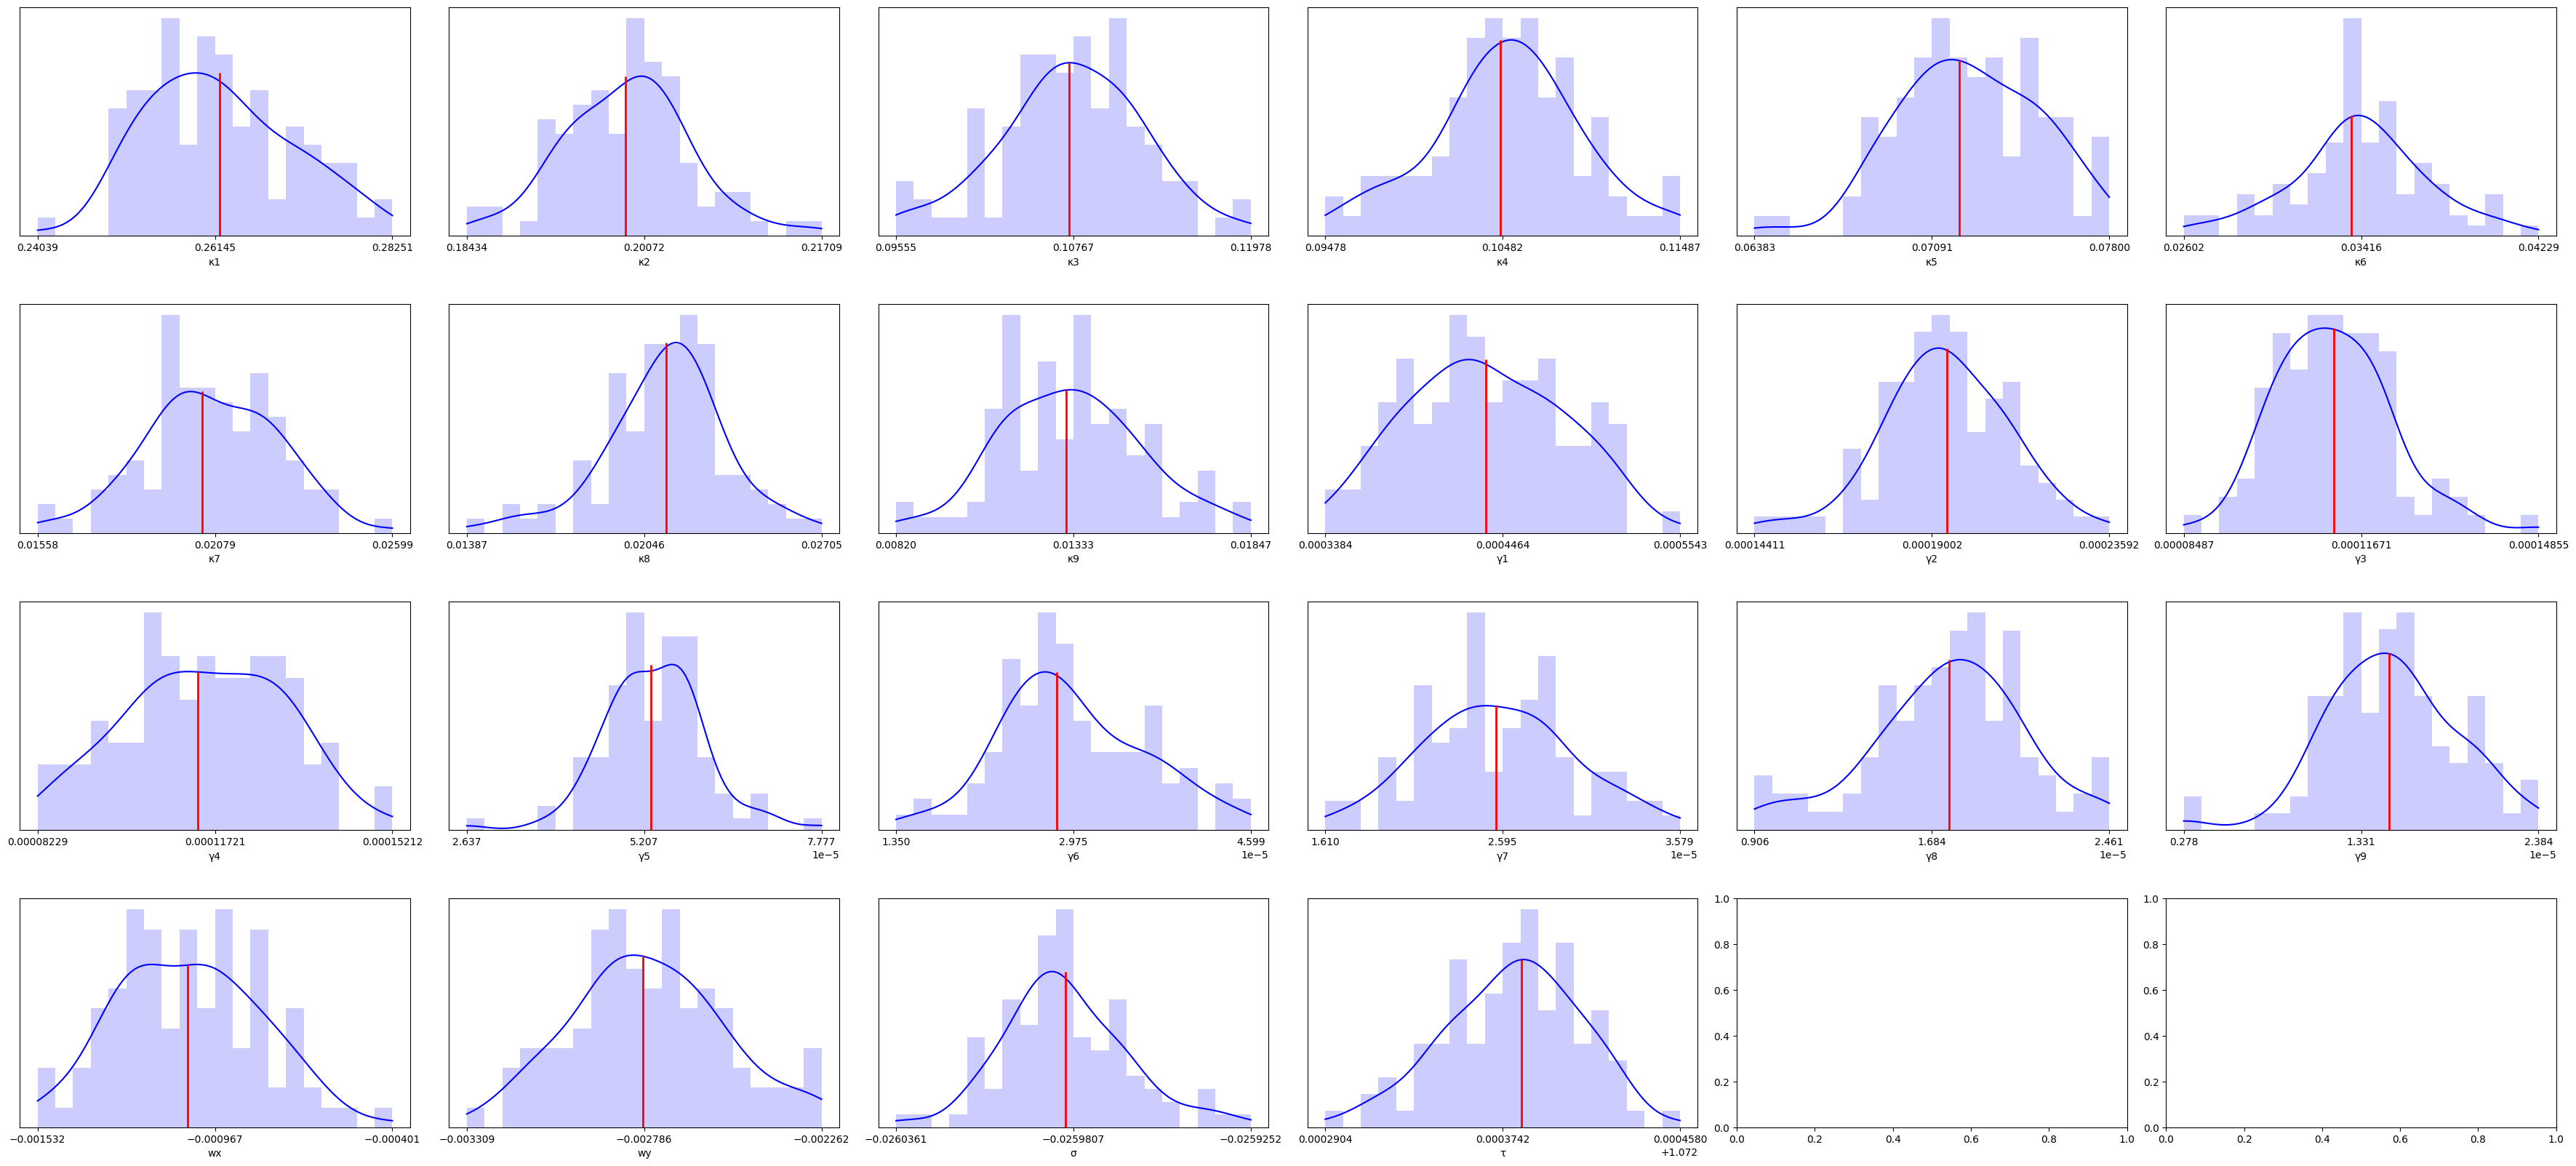

In [7]:
m = 6
n = 4
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.hstack([["\u03BA%d"%i for i in range(1,10)], 
                    ["\u03B3%d"%i for i in range(1,10)], 
                    "wx" ,"wy", "\u03C3", "\u03C4"])
sgrad2 = np.stack([sgrad[i][1] for i in range(len(sgrad))],axis = 1)
for i in range(m):
    for j in range(n):
        if i + j*m >= par.size:
            break
        tx = np.linspace(sgrad2[i + j*m,:].min(),sgrad2[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad2[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad2[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)